# 대용량 데이터 효과적으로 사용하기 with HDF5

- HDF5는 5버전의 HDF(계층적 데이터 형식)을 뜻함
- 용량이 매우 큰 데이터에 효과적으로 접근하기 위해 만들어진 데이터
- 과학이나 공학 응용분야에서 주로 쓰임
- 하나 이상의 그룹을 가질수 있기에 메모리 차원에서 이득인 데이터 형태

In [6]:
import h5py

In [ ]:
import numpy
import matplotlib.pyplot as plt
import zipfile
import imageio
import os

In [5]:
# location of the HDF5 package, yours may be under /gan/ not /myo_gan/
hdf5_file = '/content/drive/MyDrive/동훈/딥러닝 스터디/GAN/DATA/celeba_aligned_small.h5py'

#### 기존 이미지 데이터 HDF5확장자로 만들기

In [7]:
%%time



# how many of the 202,599 images to extract and package into HDF5
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile('/content/drive/MyDrive/동훈/딥러닝 스터디/GAN/DATA/celeb_image.zip', 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # extract image
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # add image data to HDF5 file with new name
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)

          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass

          # stop when total_images reached
          if (count == total_images):
            break
          pass

        pass
      pass

<timed exec>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: user 3min 7s, sys: 12 s, total: 3min 19s
Wall time: 4min 27s


### HDF5 DATA 열기

In [ ]:
with h5py.File(hdf5_file, 'r') as file_object:

  for group in file_object:
    print(group)
    pass

img_align_celeba


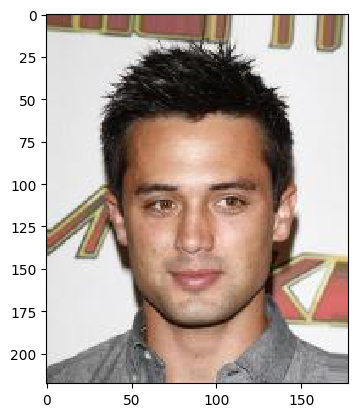

In [ ]:
with h5py.File(hdf5_file, 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['6.jpg'])
  plt.imshow(image, interpolation='none')
  pass

In [ ]:
image.shape

(218, 178, 3)

# Face GAN

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

## CUDA check and set up

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

## Dataset class

In [ ]:
class CelabDataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index) :
        #hy5y 형태의 경우 IndexError가 아닌 다른 오류가 발생
        if (index >= len(self.dataset)):
            raise IndexError()
        img = numpy.array(self.dataset[str(index)+ '.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0


    def plot_image(self,index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')




In [ ]:
celeba_dataset = CelabDataset(hdf5_file)

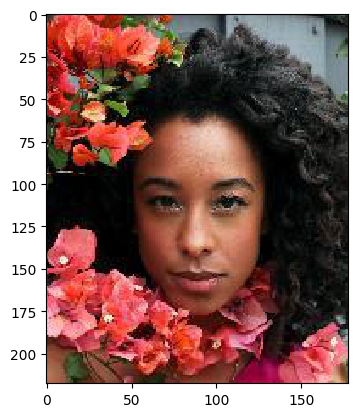

In [ ]:
celeba_dataset.plot_image(43)

## Functions

In [ ]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data


꼭 필요한 함수인가? pytorch에서 flatten()기능 없나

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

## 판별자 네트워크

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            View(218*178*3),
            #nn.Flatten(),
            #Flatten은 배치까지 고려하기 때문에 (1,3,218,178) 사이즈라면 정상적으로 동작한다.

            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),

            nn.LayerNorm(100),

            nn.Linear(100,1),
            nn.Sigmoid()

        )

        self.loss_function = nn.BCELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

        self.counter = 0
        self.progress =[]

    def forward(self,inputs):
        return self.model(inputs)


    def train(self, inputs, targets):

        outputs = self.model(inputs)

        loss = self.loss_function(outputs, targets)

        self.counter += 1;
        if self.counter%10 == 0 :
            self.progress.append(loss.item())

        if (self.counter%1000==0):
            print('counter = ', self.counter)


        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass


판별자 테스트

In [ ]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator()
# move model to cuda device
D.to(device)

for image_data_tensor in celeba_dataset:
    # print(image_data_tensor.shape)
    # print(D.forward(image_data_tensor).shape)

    # real data
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))



counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 4min 1s, sys: 3.28 s, total: 4min 4s
Wall time: 4min 38s


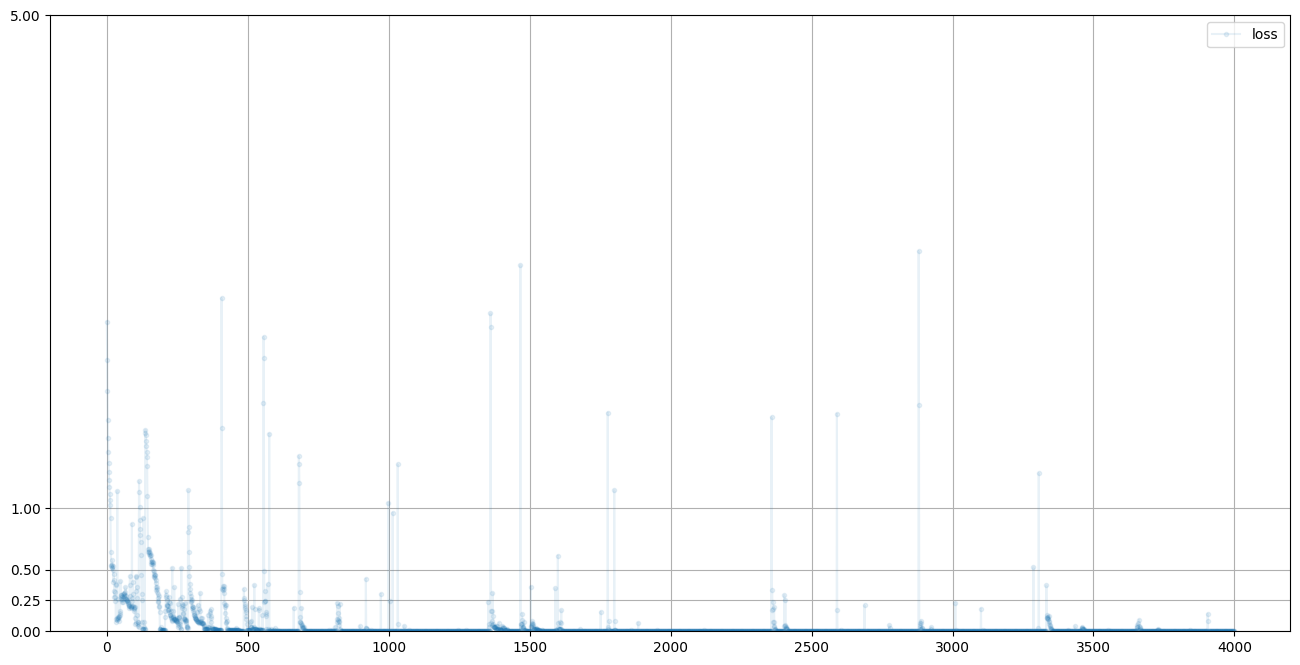

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

0.9999624490737915
0.9999128580093384
0.9999499320983887
0.9999067783355713
0.0003599122865125537
0.00036110071232542396
0.00033298658672720194
0.00036014034412801266


## 생성자 네트워크

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),

            nn.LayerNorm(3*10*10),

            nn.Linear(3*10*10,3*218*178),
            nn.Sigmoid(),

            View((218,178,3))
        )

        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

        self.counter = 0
        self.progress =[]

        pass

    def forward(self,inputs):
        return self.model(inputs)

    def train(self, D, inputs, targets):
        #이미지 생성
        g_output = self.forward(inputs)

        #생성한 값을 판별
        d_output = D.forward(g_output)

        #판별한 값과 loss계산
        loss = D.loss_function(d_output, targets)

        #로깅
        self.counter +=1;
        if self.counter%10==0:
            self.progress.append(loss.item())

            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

생성자 테스트

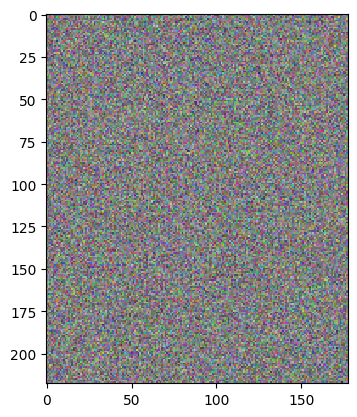

In [ ]:
G = Generator()

G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## GAN 학습

In [ ]:
%%time

D = Discriminator()
G = Generator()
D.to(device)
G.to(device)

epochs = 1

for epoch in range(epochs):
    print('epoch = ', epoch+1)

    for image_data_tensor in celeba_dataset:

        D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

        D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

        G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))



epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000
CPU times: user 8min 58s, sys: 4.1 s, total: 9min 2s
Wall time: 9min 20s


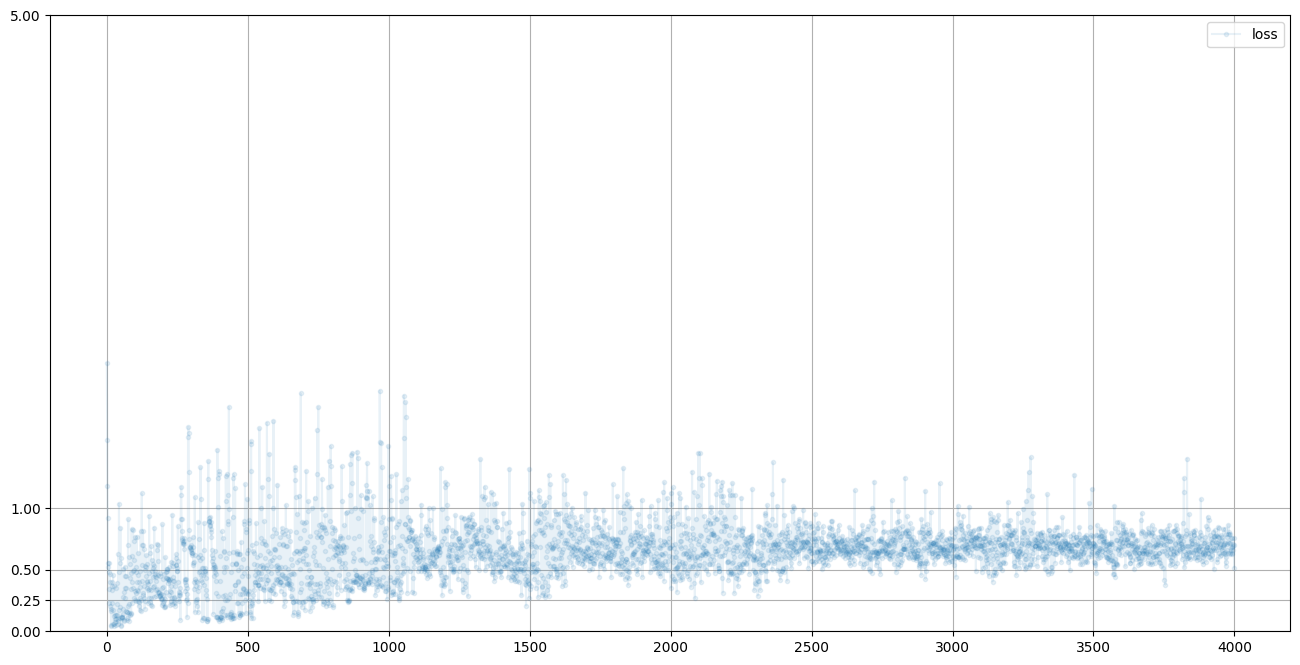

In [ ]:
D.plot_progress()

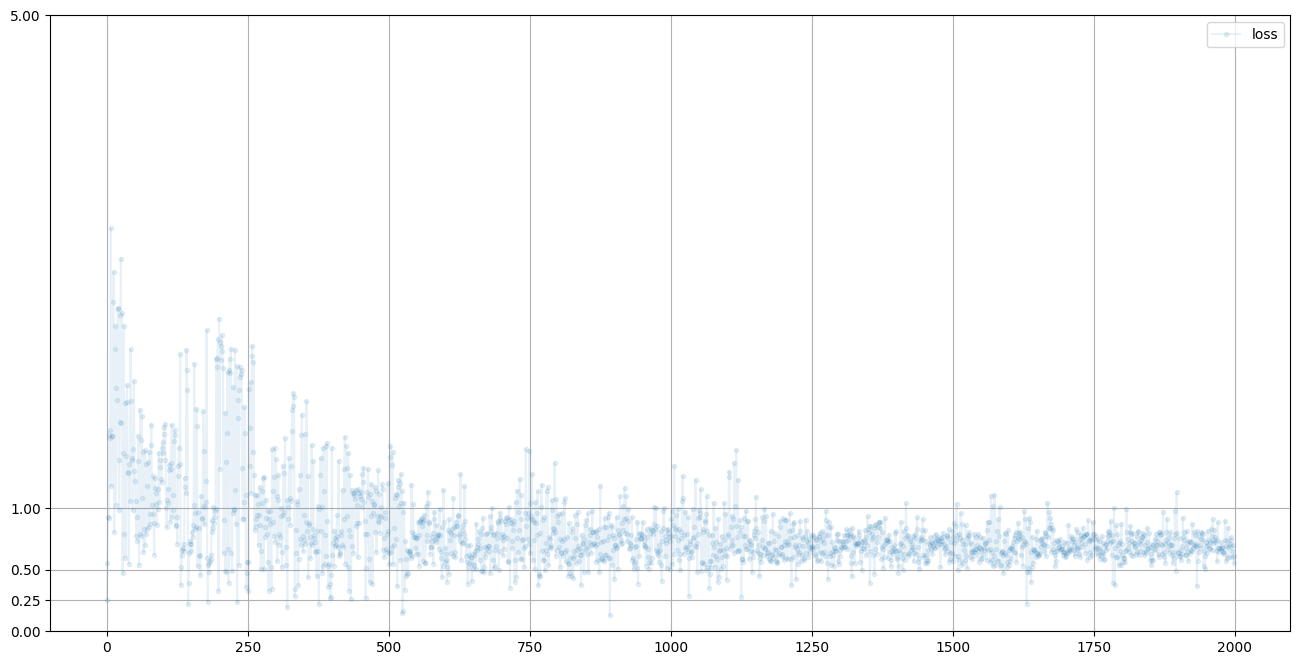

In [ ]:
G.plot_progress()

## 학습한 모델로 이미지 생성

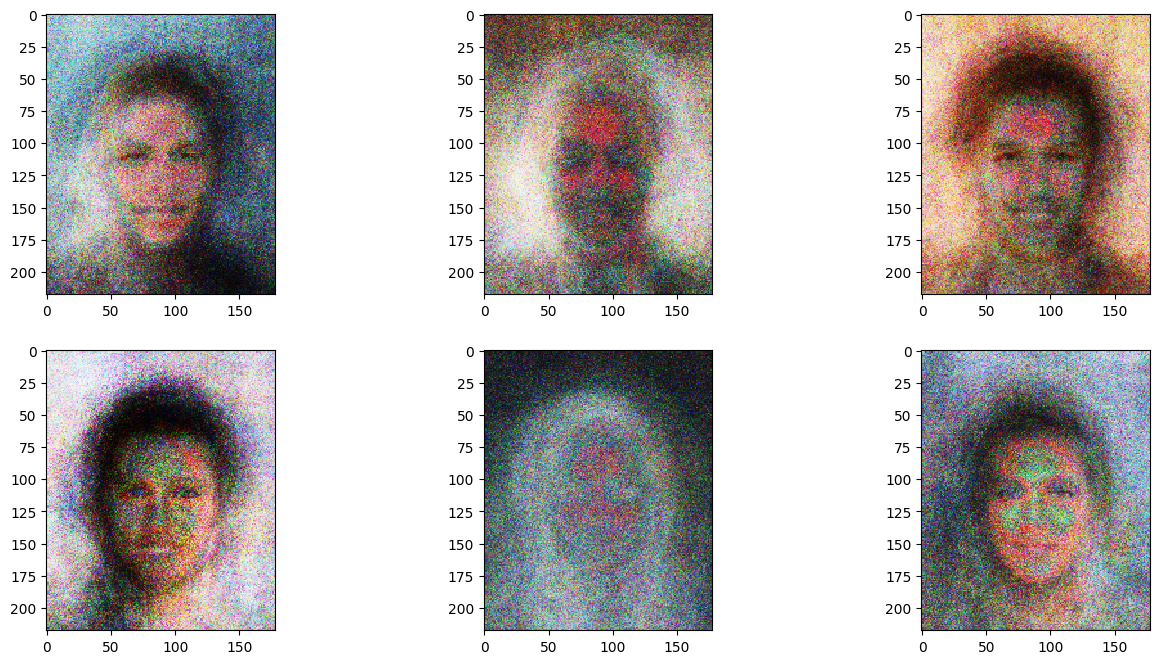

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

#Memory 사용 확인

In [ ]:
# current memory allocated to tensors (in Gb)
# (1024*1024*1024)로 나누는 것은 바이트에서 기가로 바꾸는 작업

torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.9791173934936523

* 0.97 기가바이트의 메모리가 텐서에 할당된 상태
* 이 메모리에는 판별자와 생정자 안의 데이터가 들어있음. 다시 사용될 여지가 있으므로 사라진 상태가 아님.

In [ ]:
# total memory allocated to tensors during program (in Gb)
#실행중 도달한 최대 메모리 사용량

torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

1.2436742782592773

In [ ]:
# summary of memory consumption

print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    868 MiB |   1273 MiB |  19259 GiB |  19258 GiB |
|---------------------------------------------------------------------------|
| Active memory         |    868 MiB |   1273 MiB |  19259 GiB |  19258 GiB |
|---------------------------------------------------------------------------|
| Requested memory      |    864 MiB |   1267 MiB |  19213 GiB |  19212 GiB |
|---------------------------------------------------------------

이 수치들을 통해 함수를 개량하면 메모리가 얼마나 줄어드는지 확인할 수 있다.